The goal is to combine box score files and schedule files from Jordan to create a game-level dataset, compute team and game-level features and then build a simple classification model to predict which statistics are most important for winning games. 

In [1]:
import pandas as pd
import numpy as np

# load the datasets and rename the column game_id so it matches for merging
df1 = pd.read_csv("BoxScoreData.csv")
df2 = pd.read_csv("ScheduleData.csv").rename(columns={"game_id": "Game_ID"})

# convert columns to numbers, converts non-parseble values to NaN to avoid throwing errors
df1["Game_ID"] = pd.to_numeric(df1["Game_ID"], errors="coerce").astype("Int64")
df2["Game_ID"] = pd.to_numeric(df2["Game_ID"], errors="coerce").astype("Int64")

# merge the two tables on Game_ID, if a game exists in boxScore but not in scheduleData it's dropped
combined_df = pd.merge(df1, df2, how="inner", on="Game_ID")

# Check for my own sanity
print("Combined shape:", combined_df.shape)
print("Columns:", combined_df.columns.tolist())
print("\nSample rows:")
print(combined_df.head())


Combined shape: (77211, 35)
Columns: ['Unnamed: 0_x', 'Game_ID', 'Player_Name', 'Player_ID', 'Starter', 'Home', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+/-', 'Unnamed: 0.1', 'Unnamed: 0_y', 'Home Team', 'Away Team', 'Home Score', 'Away Score', 'url', 'OT']

Sample rows:
   Unnamed: 0_x  Game_ID        Player_Name  Player_ID  Starter  Home     MP  \
0             0        0     Tyson Chandler  chandty01     True  True  36:48   
1             1        0      Toney Douglas  douglto01     True  True  35:04   
2             2        0  Amar'e Stoudemire  stoudam01     True  True  34:42   
3             3        0      Landry Fields  fieldla01     True  True  33:52   
4             4        0    Carmelo Anthony  anthoca01     True  True  33:35   

   FG  FGA    FG%  ...  GmSc   +/-  Unnamed: 0.1  Unnamed: 0_y  \
0   1    2  0.500  ...  11.3  -5.0             0           0.0   
1   8   19  0.421  

Now we go from player rows to team rows (per game)

In [2]:
# creating exactly two rows for each game - one for the home side and one for away
team_stats = (
    combined_df.groupby(["Game_ID", "Home"])
    [["FG", "FGA", "3P", "3PA", "FT", "FTA", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"]]
    .sum()
    .reset_index()
)
# Field goal, Field goal attempt, Three-pointer, Free throw, Free throw attempt, Offensive rebound, Defensive rebound, Total rebounds, Assist, Steal, Block, Turnover, Personal Foul, Points

# meta collapses the schedule info to one row per game, it adds Home Team and Away Team and the final scores to both teams of that row
meta = combined_df[["Game_ID", "Home Team", "Away Team", "Home Score", "Away Score"]].drop_duplicates()
team_stats = team_stats.merge(meta, on="Game_ID", how="left")

# for the home row team = Home team and opponent = Away team
team_stats["Team"] = team_stats.apply(
    lambda x: x["Home Team"] if x["Home"] else x["Away Team"], axis=1
)
# the same but flipped
team_stats["Opponent"] = team_stats.apply(
    lambda x: x["Away Team"] if x["Home"] else x["Home Team"], axis=1
)

# it's a Win (1) if Home score > Away score and the other way around
team_stats["Win"] = team_stats.apply(
    lambda x: 1 if (
        (x["Home"] and x["Home Score"] > x["Away Score"]) or
        (not x["Home"] and x["Away Score"] > x["Home Score"])
    ) else 0, axis=1
)

# check for my own sanity
print("Shape:", team_stats.shape)
print("Columns:", team_stats.columns.tolist())
print("\nSample rows:")
print(team_stats.head())
print("\nWin distribution:")
print(team_stats["Win"].value_counts())

Shape: (7612, 24)
Columns: ['Game_ID', 'Home', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Home Team', 'Away Team', 'Home Score', 'Away Score', 'Team', 'Opponent', 'Win']

Sample rows:
   Game_ID   Home  FG  FGA  3P  3PA  FT  FTA  ORB  DRB  ...  TOV  PF  PTS  \
0        0  False  39   76   2    5  24   31   13   28  ...   18  28  104   
1        0   True  35   74   9   20  27   34    8   23  ...   16  25  106   
2        1  False  38   78   4    7  25   36   15   36  ...   22  28  105   
3        1   True  31   82   9   28  23   30    8   23  ...   17  29   94   
4        2  False  36   89   7   15   9   14   16   25  ...   14  21   88   

            Home Team       Away Team  Home Score  Away Score  \
0     New York Knicks  Boston Celtics         106         104   
1     New York Knicks  Boston Celtics         106         104   
2    Dallas Mavericks      Miami Heat          94         105   
3    Dallas Mavericks      Miami H

Wins equals losses which is great, now we do a logistic regression model as a first step:

Accuracy: 0.495075508864084

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.48      0.49       762
           1       0.49      0.51      0.50       761

    accuracy                           0.50      1523
   macro avg       0.50      0.50      0.50      1523
weighted avg       0.50      0.50      0.50      1523


Predictors:
   Feature  Coefficient
5      FTA     0.043611
4       FT     0.043590
1      FGA     0.042816
2       3P     0.039569
12     TOV     0.030878
6      ORB     0.011753
14     PTS     0.000919
9      AST    -0.002036
11     BLK    -0.007300
3      3PA    -0.012103
8      TRB    -0.029725
10     STL    -0.031026
0       FG    -0.035684
7      DRB    -0.044707
13      PF    -0.104489


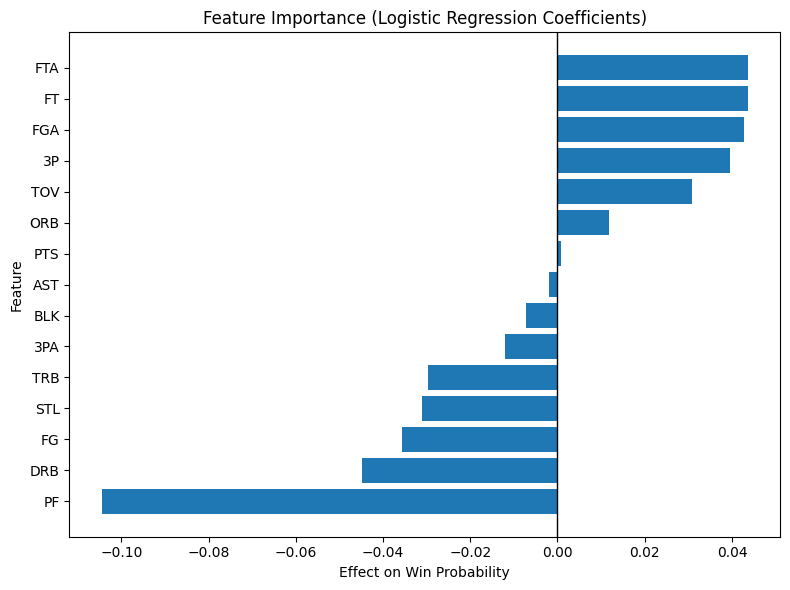

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# X = numeric team game stats (one row = one team in a game), target Y = 1 or 0
X = team_stats[["FG","FGA","3P","3PA","FT","FTA","ORB","DRB","TRB","AST","STL","BLK","TOV","PF","PTS"]]
y = team_stats["Win"]

# split the data into train and test data (80/20), stratify keeps the win/loss balance similar in both splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18, stratify=y)

# standardize each feature (computed only on train data) because log regression optimizes better when features are on similar scales. 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# evaluate on the test set
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# get feature importance (coefficients)
importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

print("\nPredictors:")
print(importance.head(15))

# sort coefficents by magnitude and create horizontal bar chart
importance_sorted = importance.sort_values(by="Coefficient", ascending=True)
plt.figure(figsize=(8,6))
plt.barh(importance_sorted["Feature"], importance_sorted["Coefficient"])
plt.axvline(0, color="black", linewidth=1)
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Effect on Win Probability")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Why is turnover positive? The accuracy is basically the same as guessing so this model isn't learning any meaningful patterns.
In the classification report; precision = when the model predicts a win, how often is it correct?, recall = of all real wins, how many did it correctly predict, f1-score = balance of precision and recall, support = number of examples for each class. I believe the problem is that we are training on absolute stats but we have to put it in context to the opponent. 

Anyways, we improve the model now:

Accuracy: 0.5344714379514117

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.55      0.54       762
           1       0.54      0.52      0.53       761

    accuracy                           0.53      1523
   macro avg       0.53      0.53      0.53      1523
weighted avg       0.53      0.53      0.53      1523


Top positive predictors:
    Feature  Coefficient  OddsRatio
   ORB_diff     0.107306   1.113274
FG_pct_diff     0.101217   1.106517
3P_pct_diff     0.075984   1.078945
FT_pct_diff     0.067225   1.069537
       Home     0.062619   1.064621
   DRB_diff     0.038994   1.039765
        STL     0.021526   1.021759
        BLK     0.011346   1.011410
   BLK_diff     0.010899   1.010959
     FT_pct     0.009152   1.009194

Top negative predictors:
 Feature  Coefficient  OddsRatio
PTS_diff    -0.198469   0.819985
 PF_diff    -0.184684   0.831367
TOV_diff    -0.119305   0.887537
STL_diff    -0.081775   0.921479
AST_di

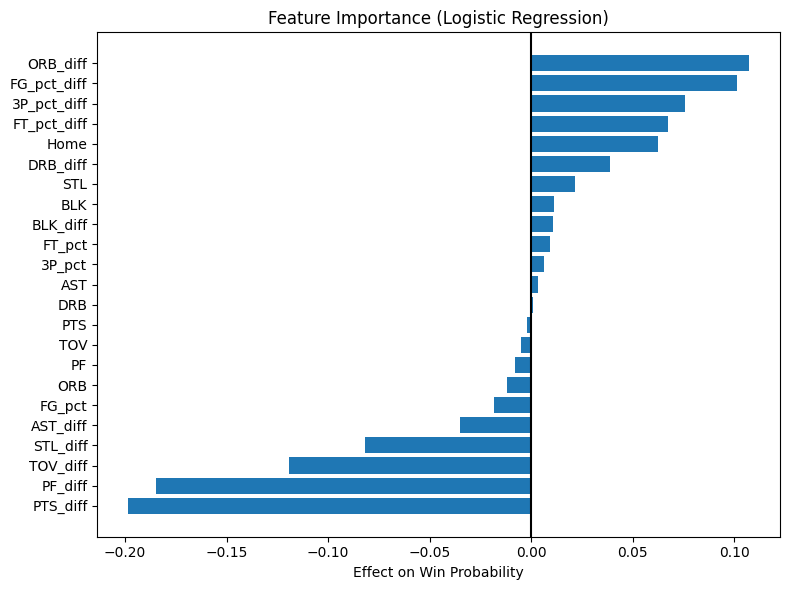

In [4]:
import numpy as np
from sklearn.pipeline import Pipeline

# create a new function build_features to make it easier to reuse
def build_features(team_df: pd.DataFrame):

    # we focus on the relevant columns and copy them to avoid problems
    df = team_df[[
        "Game_ID", "Home", "Win",
        "FG", "FGA", "3P", "3PA", "FT", "FTA", "PTS",
        "ORB", "DRB", "AST", "STL", "BLK", "TOV", "PF"
    ]].copy()

    # add percentages of field goal, threepointers, and fre throws (effectiveness measures) to improve predictiveness
    df["FG_pct"] = np.where(df["FGA"] > 0, df["FG"] / df["FGA"], 0.0)
    df["3P_pct"] = np.where(df["3PA"] > 0, df["3P"] / df["3PA"], 0.0)
    df["FT_pct"] = np.where(df["FTA"] > 0, df["FT"] / df["FTA"], 0.0)

    # then we build the opponents table
    opp_cols = [
        "Game_ID", "Home",
        "FG_pct", "3P_pct", "FT_pct",
        "ORB", "DRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"
    ]
    opp = df[opp_cols].copy()
    opp["Home"] = ~opp["Home"]          
    opp = opp.add_prefix("opp_")        

    # now we merge
    df = pd.merge(
        df,
        opp,
        left_on=["Game_ID", "Home"],
        right_on=["opp_Game_ID", "opp_Home"],
        how="left",
        validate="many_to_one"
    )

    # differentiate the features, home team minus opponent team. 
    diff_stats = ["FG_pct", "3P_pct", "FT_pct",
                  "ORB", "DRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"]
    for stat in diff_stats:
        df[f"{stat}_diff"] = df[stat] - df[f"opp_{stat}"]

    # final feature matrix
    feature_cols = [
        # your efficiencies
        "FG_pct", "3P_pct", "FT_pct",
        # your box score counts
        "ORB", "DRB", "AST", "STL", "BLK", "TOV", "PF", "PTS",
        # differences vs opponent
        "FG_pct_diff", "3P_pct_diff", "FT_pct_diff",
        "ORB_diff", "DRB_diff", "AST_diff", "STL_diff",
        "BLK_diff", "TOV_diff", "PF_diff", "PTS_diff",
        # home-court indicator
        "Home",
    ]

    X = df[feature_cols].copy()
    y = df["Win"].astype(int)

    return X, y


# let's train the model
def train_logreg(X: pd.DataFrame, y: pd.Series, seed: int = 18):
    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=seed
    )

    # scale the features (normalization) and perform logistic regression
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=5000))
    ])

    pipe.fit(X_train, y_train)

    # evaluation on the test set
    y_pred = pipe.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    coefs = pipe.named_steps["lr"].coef_[0]
    importance = pd.DataFrame({
        "Feature": X.columns,
        "Coefficient": coefs
    }).sort_values("Coefficient", ascending=False)
    importance["OddsRatio"] = np.exp(importance["Coefficient"])

    print("\nTop positive predictors:")
    print(importance.head(10).to_string(index=False))

    print("\nTop negative predictors:")
    print(importance.tail(10).sort_values("Coefficient").to_string(index=False))

    return pipe, importance


# run this shit
X, y = build_features(team_stats)
model, importance = train_logreg(X, y, seed=42)

importance_sorted = importance.sort_values("Coefficient", ascending=True)
plt.figure(figsize=(8, 6))
plt.barh(importance_sorted["Feature"], importance_sorted["Coefficient"])
plt.axvline(0, color="black")
plt.title("Feature Importance (Logistic Regression)")
plt.xlabel("Effect on Win Probability")
plt.tight_layout()
plt.show()


The model is still not learning anything apparently

The logistic regression model achieves an accuracy of 53.4%, meaning it performs only slightly better than random guessing. Precision, recall, and F1-scores indicates that the model has a problem with strongly separate winners from losers using the available features. This suggests that team-level box score statistics, even when combined with opponent differences, does not really contain a linear correlation for predicting game outcomes. However, the feature coefficients reveal some insights. The strongest positive predictors (associated with a higher probability of winning) are ORB_diff, FG_pct_diff, 3P_pct_diff and FT_pct_diff. This means that outperforming the other team in offensive rebounding and shooting efficiency has the largest positive impact on win probability. Home court advantage also shows a positive effect. In smaller magnitudes, defensive actions such as steals and blocks also contributes. 

On the other side, the most influential negative predictors are PTS_diff, PF_diff and TOV_diff. This might look weird but since the differences are relative to the opponent, negative values here indicate that scoring fewer points, committing more fouls, or turning the ball over more often reduces the chance of winning which makes a lot of sense. Other negative features include STL_diff, AST_diff and FG_pct (multicollinearity). 

Overall, the model still reflects realistic basketball relationships - teams that shoot more efficiently, rebound better, commit fewer fouls, tend to win more often. However, logistic regression struggles to capture the full complexity of NBA games using only the data that we have since the accuracy is still not where we want it. It stays around 53% because the input features do not cleanly separate winners from losers in a linear way. Many games are decided by complex factors that box scores cannot capture alone, such as shot quality, pace, lineup matches and late-game situations. In this structure, the winners and losers, share similar stat profiles which causes large overlap between classes. Logistic regression (linear model) cannot easily learn the non-linear relationships and noise that we have. As a result, it finds meaningful basketball trends (like shooting efficiency) but cannot consistently predict outcomes better than chance. 

That is why we will use Random Forest now to catch these non-linear relationship and achieve higher accuracy. 

Random Forest Accuracy: 0.757715036112935

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76       762
           1       0.76      0.76      0.76       761

    accuracy                           0.76      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.76      0.76      0.76      1523


Top features (Random Forest):
    Feature  Importance
        PTS    0.174416
   PTS_diff    0.100620
     FG_pct    0.080878
        DRB    0.065505
     3P_pct    0.064397
     FT_pct    0.056494
         PF    0.052711
       Home    0.044791
        AST    0.043771
        TOV    0.042073
        ORB    0.040054
        STL    0.039330
        BLK    0.037479
FG_pct_diff    0.030261
   AST_diff    0.017995


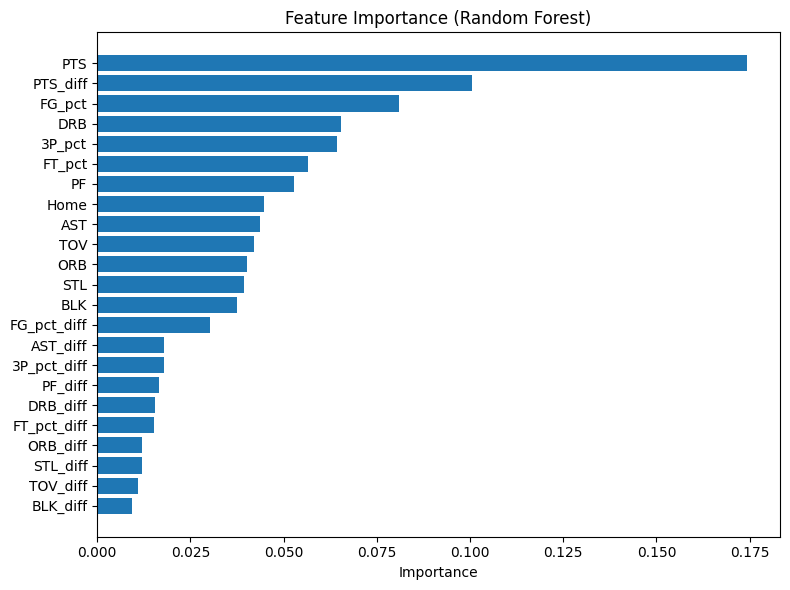

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

def train_random_forest(X: pd.DataFrame, y: pd.Series, seed: int = 27):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=seed
    )

    # let's random forest this 
    rf = RandomForestClassifier(
        n_estimators=300,      # number of trees
        max_depth=None,       # let trees grow until they run out of signal
        min_samples_leaf=2,   # small leaf to reduce overfitting a bit
        random_state=seed,
        n_jobs=-1             # use all CPU cores
    )

    rf.fit(X_train, y_train)

    # now we evaluate
    y_pred = rf.predict(X_test)
    print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
    print("\nRandom Forest Classification Report:\n",
          classification_report(y_test, y_pred))

    # feature importance from the forest
    importances = rf.feature_importances_
    importance_df = pd.DataFrame({
        "Feature": X.columns,
        "Importance": importances
    }).sort_values("Importance", ascending=False)

    print("\nTop features (Random Forest):")
    print(importance_df.head(15).to_string(index=False))

    # plot it
    importance_sorted = importance_df.sort_values("Importance", ascending=True)

    plt.figure(figsize=(8, 6))
    plt.barh(importance_sorted["Feature"], importance_sorted["Importance"])
    plt.title("Feature Importance (Random Forest)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    return rf, importance_df

# ruuuuuuun
X, y = build_features(team_stats)   # reuse the same function as before
rf_model, rf_importance = train_random_forest(X, y, seed=42)


Higher accuracy. Why? Random forest can model nonlinear interactions and treshold behaviour that logistic regression cannot. 

The Random Forest model shows a significant improvement compared to logistic regression, reaching an accuracy of 75.8%. This means that the model correctly predicts the winner in about 3 out of 4 games, using only team-level box score information and opponent differences. The precision, recall, and F1-scores are also balanced at around 0.76, showing that the model performs equally well on both wins and losses and is not biased toward either class.

The feature importance results reveal strong and intuitive basketball relationships. Points scored (PTS) and point differential (PTS_diff) are by far the most influential predictors. This makes sense because the point outcome directly determines the winner, and Random Forests can capture that relationship even when logistic regression cannot. Shooting efficiency metrics—such as FG%, 3P%, and FT%—also contribute heavily, confirming that efficient scoring is strongly associated with winning. Rebounding (DRB, ORB) and ball security metrics (TOV, STL, BLK) appear as mid-level predictors, reflecting their role in controlling possessions. Finally, the Home feature shows a noticeable positive impact, demonstrating the presence of home-court advantage.

Overall, the Random Forest model captures nonlinear interactions in the game data much better than logistic regression, leading to a substantial increase in predictive performance. The results also align well with fundamental basketball analytics: scoring more, shooting efficiently, securing rebounds, and avoiding fouls and turnovers all increase a team’s chances of winning.